<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

- Version 1 (10/23/2023)
    * EDA 
    * Baseline modeling 1.0.
    
    
- Version 2 (10/24/2023)
    * Baseline modeling 1.0 updated.
    
    
- Version 3 (10/24/2023)
    * Baseline modeling 1.0 updated (more models added).
    
    
- Version 4 (10/25/2023)
    * Baseline modeling 2.0 added.
    

- Version 5 (10/27/2023)
    * k-NN and LDA are added.
    
    
- Version 6 (10/28/2023)
    * Soft voting ensemble weight estimation.
    * Baseline modeling 1.0 updated.
    

- Version 7 (10/31/2023)
    * More data (smoking) is added.
    * Baseline modeling 2.0 updated.
    

- Version 8 (11/02/2023)
    * Original dataset is added.
    * Baseline modeling 2.0 updated.
    

- Version 9 (11/04/2023)
    * Baseline modeling 2.0 updated.
    

- Version 10 (11/07/2023)
    * Baseline modeling 2.0 updated.
    
    
- Version 11 (11/11/2023)
    * Baseline modeling 2.0 updated.


<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [3]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [4]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')
submission = pd.read_csv('../sample_submission.csv')

train_original = pd.read_csv('../train_dataset.csv')
train_original = train_original.drop_duplicates()

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)
print('The dimension of the original train dataset is:', train_original.shape)

The dimension of the train dataset is: (159256, 24)
The dimension of the test dataset is: (106171, 23)
The dimension of the original train dataset is: (33467, 23)


In [5]:
train.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,98.352552,195.796165,127.616046,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,15.329740,28.396959,66.188989,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,46.000000,77.000000,8.000000,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,115.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,165.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,375.000000,393.000000,766.000000,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [7]:
test.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
count,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000,106171.000000
mean,212341.000000,44.426538,165.221322,67.125618,82.999892,1.004776,0.999483,1.024216,1.023980,122.475403,76.820676,98.397943,195.874391,127.406203,55.922286,114.597404,14.793354,1.072798,0.892463,25.559616,26.565427,36.086888,0.195458
std,30649.072052,11.897138,8.837065,12.586569,8.946584,0.397690,0.385752,0.153719,0.152988,12.765542,9.018782,15.337904,28.435413,66.352488,14.000552,26.943401,1.434296,0.340818,0.179927,9.504442,17.944195,30.928138,0.396555
min,159256.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,46.000000,66.000000,8.000000,18.000000,1.000000,5.000000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000
25%,185798.500000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000
50%,212341.000000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,114.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000
75%,238883.500000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,164.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,33.000000,44.000000,0.000000
max,265426.000000,85.000000,190.000000,130.000000,127.700000,9.900000,9.900000,2.000000,2.000000,213.000000,140.000000,423.000000,369.000000,548.000000,148.000000,1220.000000,21.100000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000


There are no missing values neither in `train` and `test` datasets.

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

Notice that the data exploration is based on the competition dataset. First, we start by visualizing `smoking`, the variable of interest.

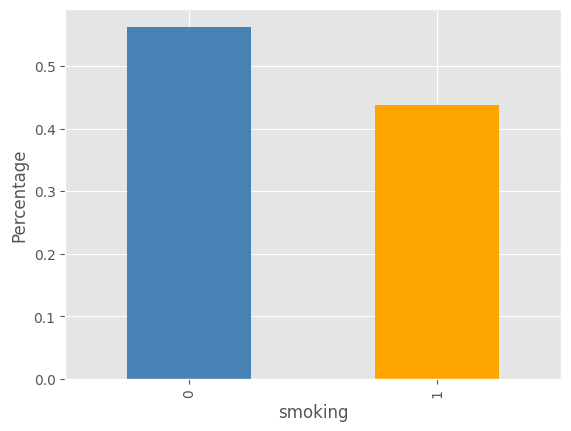

In [8]:
train['smoking'].value_counts(normalize = True).plot(kind = 'bar', color = ['steelblue', 'orange'])
plt.ylabel('Percentage');

From the above bar chart, we see the data is pretty balanced (~44% 0s and 56% 1s). Next we explore the relationship between `age` and `smoking`.

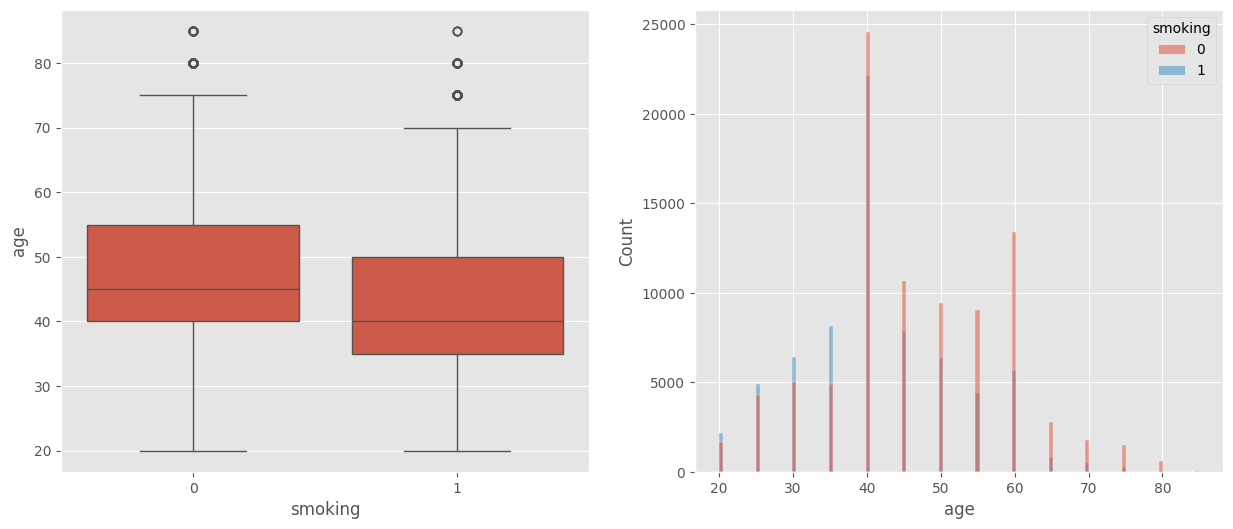

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'age');
sns.histplot(data = train, x = 'age', hue = 'smoking');

From the above, these are a couple of observations:

- From the left panel, we observe the median age of non-smokers is about 5 years larger when comapred to the median age of smokers. 
- From the right panel, it seems that age is a discrete variable.

In [10]:
print(f"There are {train['age'].nunique()} unique age values in the train dataset")
print(f"{train['age'].unique()} \n")
print(f"There are {test['age'].nunique()} unique age values in the test dataset")
print(f"{test['age'].unique()} \n")

There are 18 unique age values in the train dataset
[55 70 20 35 30 50 45 40 60 25 65 75 80 85 62 69 49 58] 

There are 18 unique age values in the test dataset
[40 80 60 55 70 45 30 25 50 35 20 75 65 85 78 69 64 24] 



Notice that the `age` values are not the same in the `train` and `test` datasets. Next, we explore the relationship between `height(cm)`, `weight(kg)`, `waist(cm)` and `smoking`.

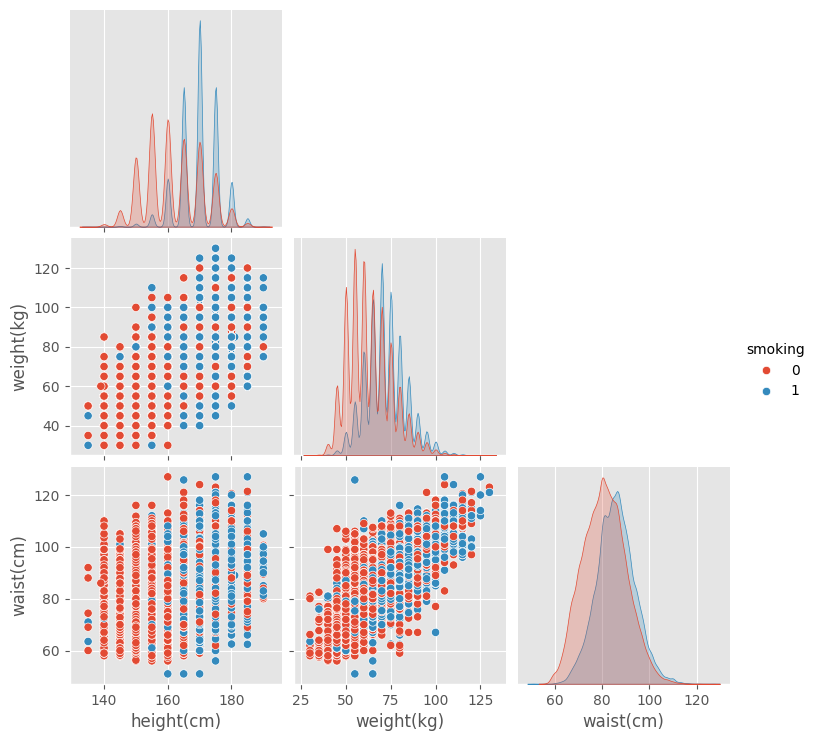

In [11]:
sns.pairplot(data = train[['height(cm)', 'weight(kg)', 'waist(cm)', 'smoking']], hue = 'smoking', corner = True);

From the above pair-plots, these are a couple of observations:

- Taller people (heavier as well) tend to smoke.
- The relationship between `weight(kg)` and `waist(cm)` is more or less linear.

Next, we explore the relationship between `eyesight` and `smoking`.

In [12]:
pd.crosstab(train['eyesight(left)'], train['smoking'], normalize = 'index')

smoking,0,1
eyesight(left),,
0.1,0.669014,0.330986
0.2,0.694143,0.305857
0.3,0.703356,0.296644
0.4,0.707522,0.292478
0.5,0.665833,0.334167
0.6,0.671148,0.328852
0.7,0.640735,0.359265
0.8,0.622629,0.377371
0.9,0.585788,0.414212


From the above, these are a couple of observations:

- 9.9 is very different from the other values.
- There are a few values (9.9, 1.6, 1.3, 1.8, 1.9, 1.1, 1.7) with low frequency.

In [13]:
pd.crosstab(train['eyesight(right)'], train['smoking'], normalize = 'index')

smoking,0,1
eyesight(right),,
0.1,0.704857,0.295143
0.2,0.694311,0.305689
0.3,0.716919,0.283081
0.4,0.700000,0.300000
0.5,0.678143,0.321857
0.6,0.690966,0.309034
0.7,0.652750,0.347250
0.8,0.637278,0.362722
0.9,0.568484,0.431516


From the above, these are a couple of observations:

- 9.9 is very different from the other values.
- There are a few values (9.9, 1.6, 1.3, and 1.4) with low frequency.

Next, we explore the relationship between `hearing` and `smoking`.

In [14]:
pd.crosstab(train['hearing(left)'], train['smoking'], normalize = 'index')

smoking,0,1
hearing(left),,
1,0.559664,0.440336
2,0.683604,0.316396


In [15]:
pd.crosstab(train['hearing(right)'], train['smoking'], normalize = 'index')

smoking,0,1
hearing(right),,
1,0.559804,0.440196
2,0.680697,0.319303


From the above, these are a couple of observations;

- When `hearing = 1` about 56% are non-smokers (regardless right or left).
- When `hearing = 2` about 68% are non-smokers (regardless right or left).


Next, we explore the relationship between `systolic` and `smoking`.

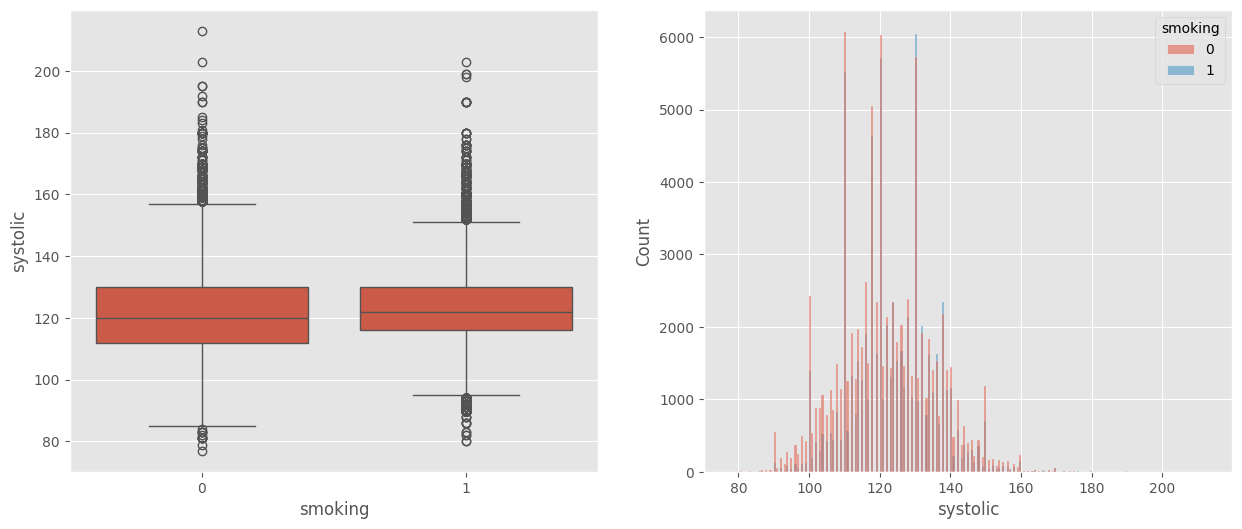

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'systolic');
sns.histplot(data = train, x = 'systolic', hue = 'smoking');

The `systolic` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`relaxation` and `smoking`.

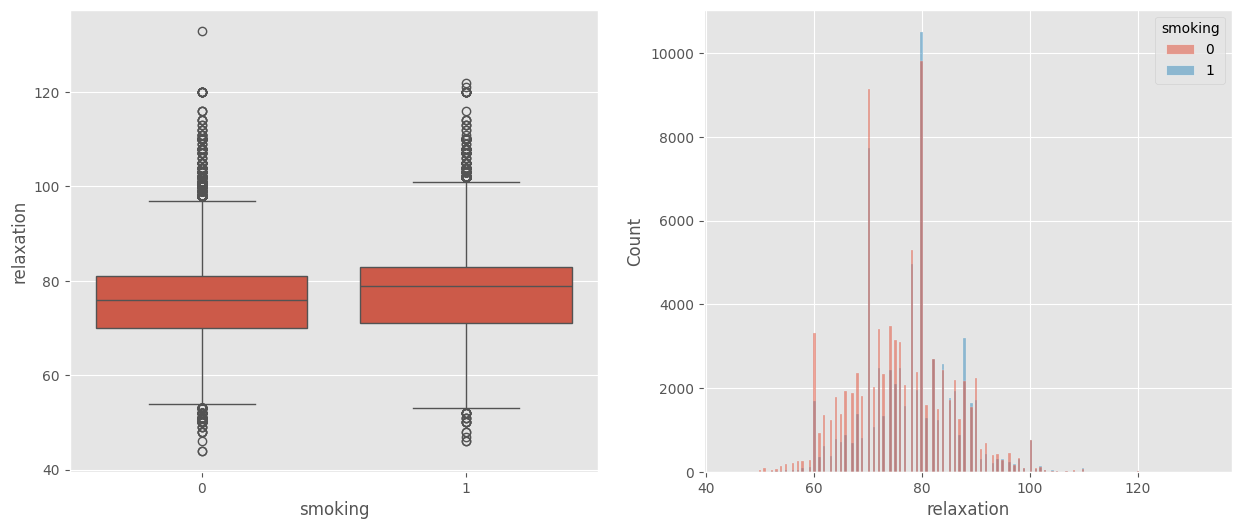

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'relaxation');
sns.histplot(data = train, x = 'relaxation', hue = 'smoking');

The `relaxation` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`fasting blood sugar` and `smoking`.

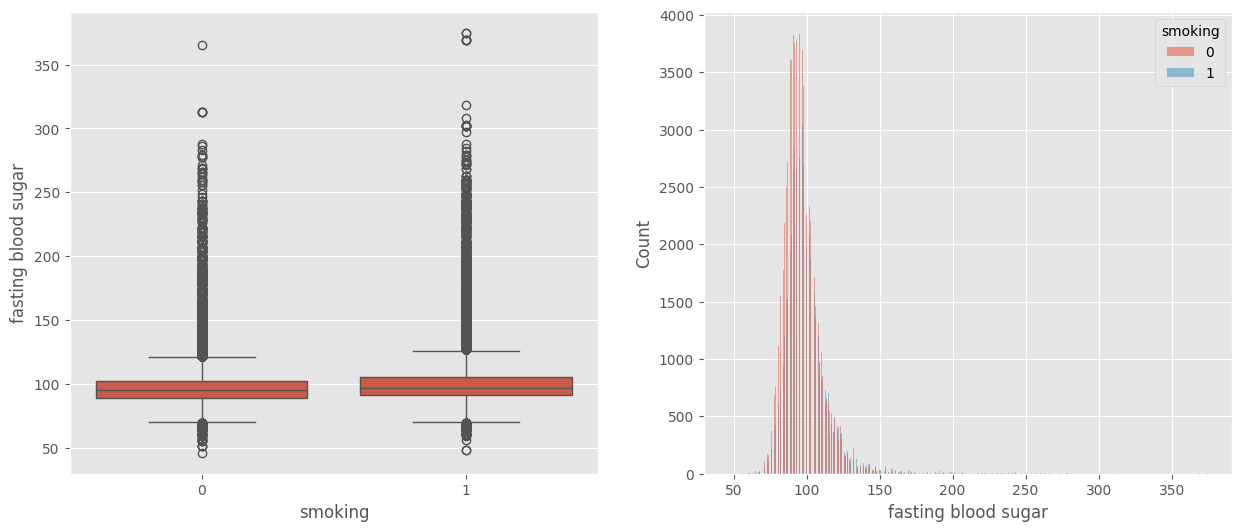

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'fasting blood sugar');
sns.histplot(data = train, x = 'fasting blood sugar', hue = 'smoking');

The `fasting blood sugar` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`Cholesterol` and `smoking`.

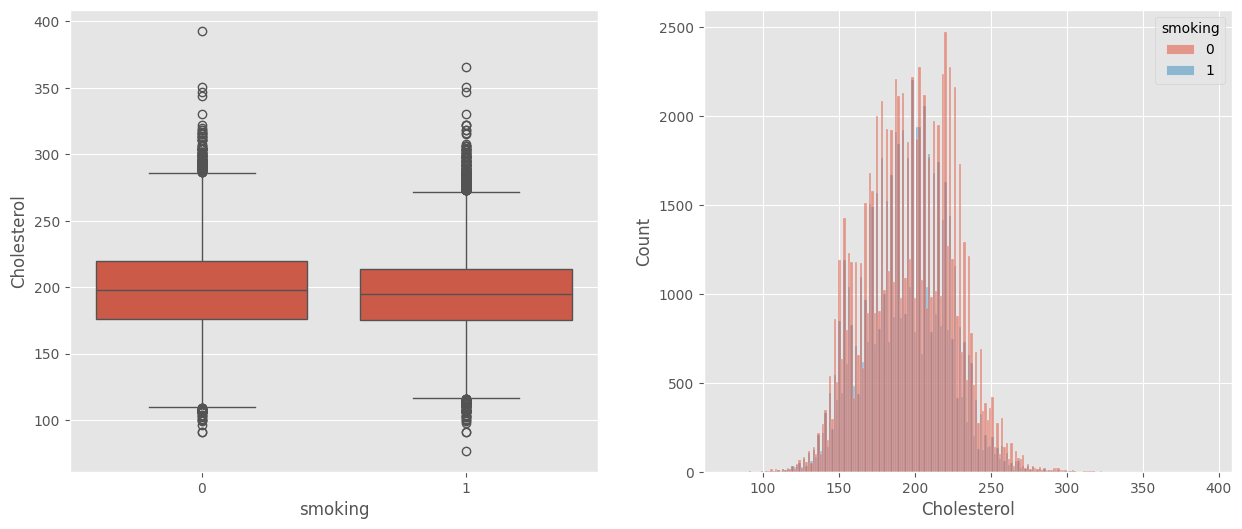

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'Cholesterol');
sns.histplot(data = train, x = 'Cholesterol', hue = 'smoking');

The `Cholesterol` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between`triglyceride` and `smoking`.

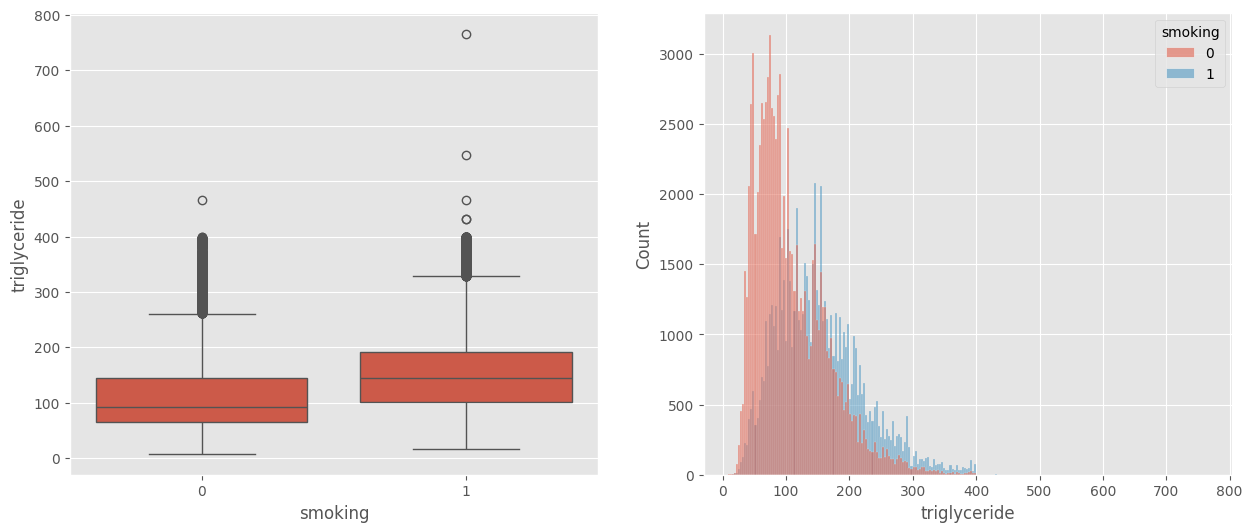

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'triglyceride');
sns.histplot(data = train, x = 'triglyceride', hue = 'smoking');

From the above chart, we see the smokers, on average, have higher `triglyceride`. Next, we explore the relationship between `HDL` and `smoking`.

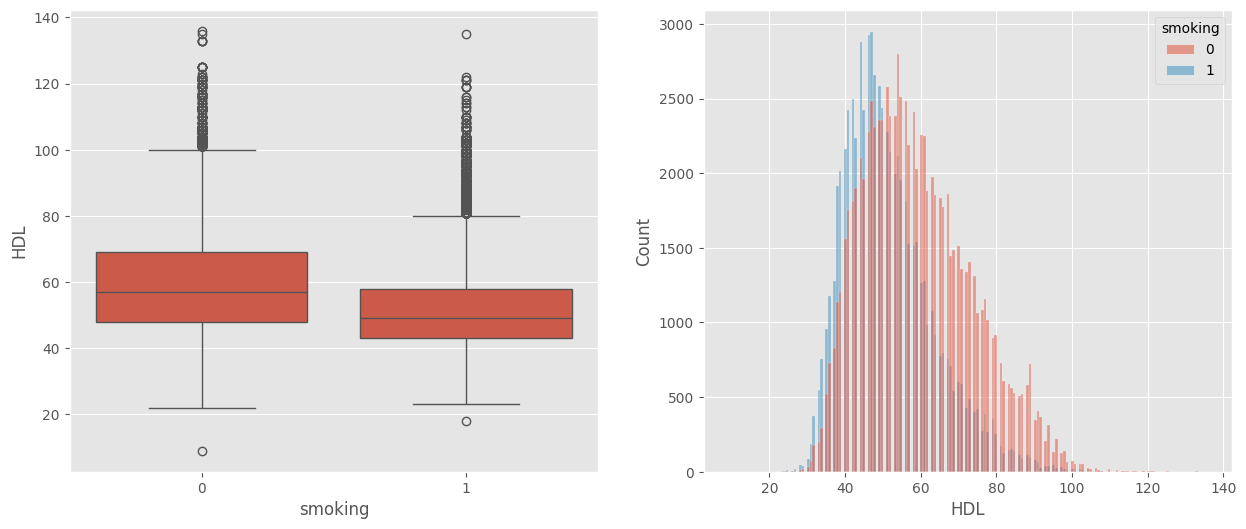

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'HDL');
sns.histplot(data = train, x = 'HDL', hue = 'smoking');

From the above charts, we see that non-smokers, on average, have higher `HDL` than smokers. Next, we explore the relationship between `LDL` and `smoking`.

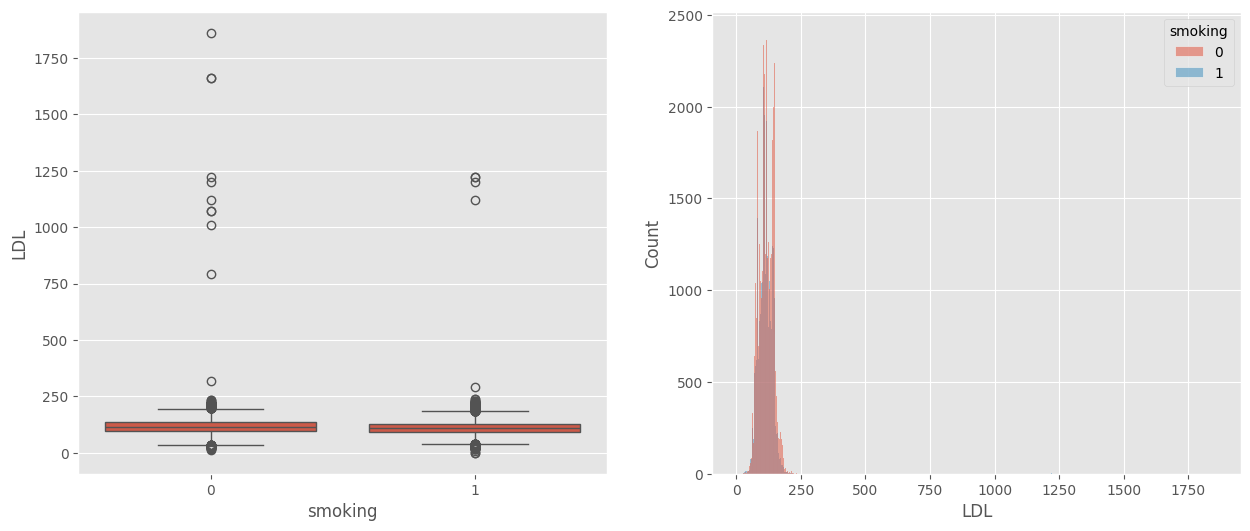

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'LDL');
sns.histplot(data = train, x = 'LDL', hue = 'smoking');

The `LDL` distributions of non-smokers and smokers are very similar. Next, we explore the relationship between `hemoglobin` and `smoking`.

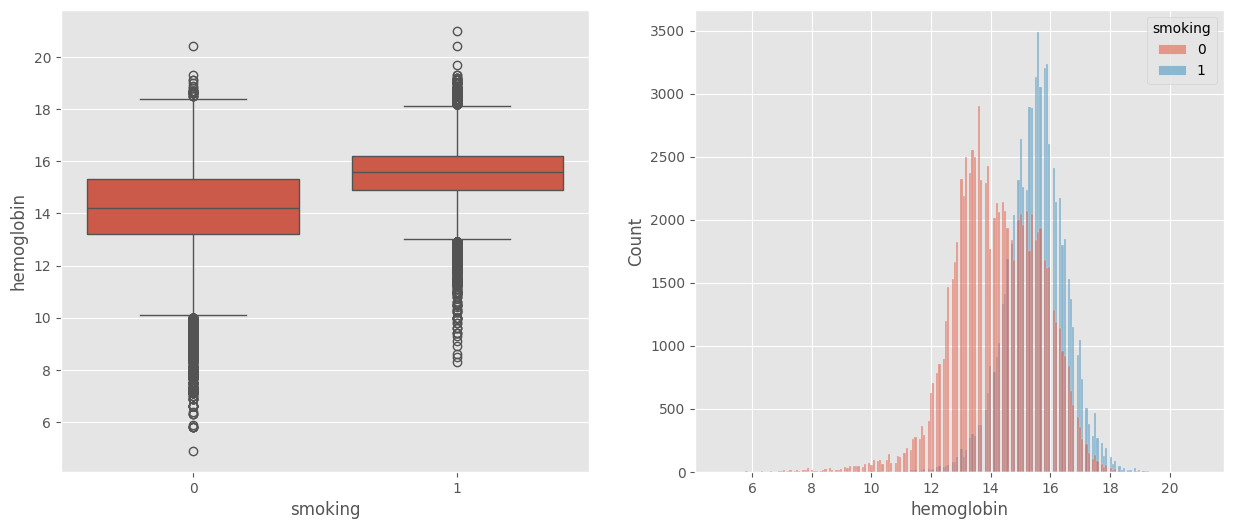

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'hemoglobin');
sns.histplot(data = train, x = 'hemoglobin', hue = 'smoking');

From the above, it is clear the `hemoglobin` of smokers, on average, is higher. Next we explore the relationship between `Urine protein` and `smoking`.

In [24]:
pd.crosstab(train['Urine protein'], train['smoking'])

smoking,0,1
Urine protein,,
1,84311,66551
2,3549,2060
3,1402,826
4,287,190
5,48,26
6,6,0


Notice that there are only six observations with `Urine protein = 6`. Next we explote the relationship between `serum creatinine` and `smoking`.

In [25]:
pd.crosstab(train['serum creatinine'], train['smoking'])

smoking,0,1
serum creatinine,,
0.1,4,13
0.2,3,0
0.3,4,1
0.4,298,13
0.5,2444,180
0.6,10161,992
0.7,15583,4199
0.8,18540,11262
0.9,16637,19139


From the above table, there are a couple of `serum creatinine` values that are different from the others (5.9, 7.4, and 9.9). Next, we explore the relationship between `Gtp` and `smoking`.

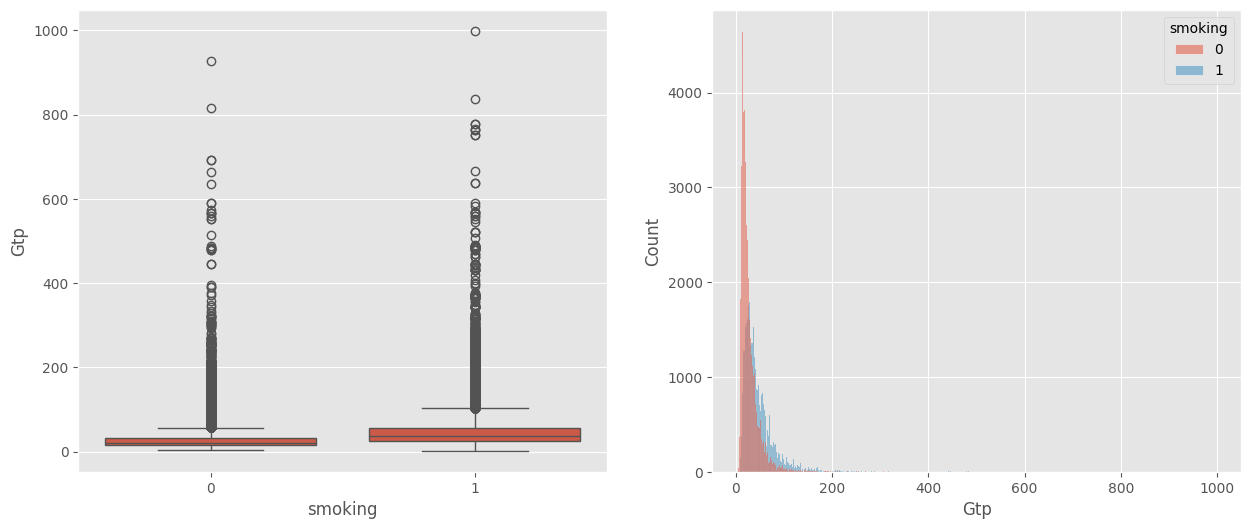

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'Gtp');
sns.histplot(data = train, x = 'Gtp', hue = 'smoking');

From the above, smokers, on average, have a higher `Gtp`. Next, we explore the relationship between `dental caries` and `smoking`.

In [27]:
pd.crosstab(train['dental caries'], train['smoking'], normalize = 'index')

smoking,0,1
dental caries,,
0,0.588918,0.411082
1,0.456172,0.543828


From the above, we see that when `dental caries = 0`, the likelihood of being smoker is about 41%. On the other hand, when `dental caries = 1`, the likelihood of being smoker is about 54%. These are some takeaways from the initial EDA:

- The relationship between some of input features and `smoking` is not clear (or not clear distinction between the distribution of the two groups).
- Some of the features have a more clear relationship with `smoking` (`height`, `triglyceride`, and `hemoglobin`).

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We start by modeling (using standard models) with raw data with minimum transformation. First, we define the input, target variables and the cross-validation folds.

In [28]:
X = train.drop(columns = ['id', 'smoking'], axis = 1)
Y = train['smoking']

skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

First, we train the `KNeighborsClassifier` model with different number of neighbors as follows.

In [29]:
stand_tran = make_pipeline(PowerTransformer())

proccessor = make_column_transformer(
    (stand_tran, ('age', 'height(cm)',
                 'weight(kg)', 'waist(cm)',
                 'eyesight(left)', 'eyesight(right)',
                 'systolic', 'relaxation',
                 'fasting blood sugar', 'Cholesterol',
                 'triglyceride', 'HDL',
                 'LDL', 'hemoglobin',
                 'serum creatinine', 'AST',
                 'ALT', 'Gtp')), 
    remainder = 'passthrough')

knn = make_pipeline(proccessor, KNeighborsClassifier())
knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer())]),
                                                  ('age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'eyesight(left)',
                                                   'eyesight(right)',
                                                   'systolic', 'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp'))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

Next, we run a simple loop to estimate `n_neighbors`.

In [30]:
# for i in [50, 80, 120, 150, 180, 220, 250, 280, 320, 350]:
knn_cv_routine = cross_val_score(make_pipeline(proccessor, KNeighborsClassifier(n_neighbors = 220)),
                                 X,
                                 Y,
                                 scoring = 'roc_auc',
                                 cv = skf,
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the k-NN model is {knn_cv_routine.mean()}")

The average oof ROC-AUC score of the k-NN model is 0.8494156268162193


Next, we train and evaluate the oof performance of `LinearDiscriminantAnalysis` as follows.

In [31]:
poly_tran = make_pipeline(PolynomialFeatures(2, include_bias = False), StandardScaler())

proccessor = make_column_transformer(
    (poly_tran, ('age', 'height(cm)',
                 'weight(kg)', 'waist(cm)',
                 'eyesight(left)', 'eyesight(right)',
                 'systolic', 'relaxation',
                 'fasting blood sugar', 'Cholesterol',
                 'triglyceride', 'HDL',
                 'LDL', 'hemoglobin',
                 'serum creatinine', 'AST',
                 'ALT', 'Gtp')), 
    remainder = 'passthrough')

LDA = make_pipeline(proccessor, LinearDiscriminantAnalysis())
LDA

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ('age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'eyesight(left)',
                                                   'eyesight(right)',
                                                   'systolic', 'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp'))])),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

In [32]:
LDA_cv_routine = cross_val_score(LDA,
                                 X,
                                 Y,
                                 scoring = 'roc_auc',
                                 cv = skf,
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the LDA model is {LDA_cv_routine.mean()}")

The average oof ROC-AUC score of the LDA model is 0.847560632819552


Next, we train and evaluate the oof performance of `LogisticRegression` model.

In [33]:
logit = make_pipeline(proccessor, LogisticRegression(C = 0.1, 
                                                     max_iter = 2000, 
                                                     solver = 'newton-cholesky'))

Logit_cv_routine = cross_val_score(logit,
                                   X,
                                   Y,
                                   scoring = 'roc_auc',
                                   cv = skf,
                                   n_jobs = -1)

print(f"The average oof ROC-AUC score of the Logistic model is {Logit_cv_routine.mean()}")

The average oof ROC-AUC score of the Logistic model is 0.8507198486697132


After that, we run the cross-validation routine with `RandomForestClassifier`.

In [34]:
RF_cv_routine = cross_val_score(RandomForestClassifier(criterion = 'log_loss',
                                                       n_estimators = 200,
                                                       max_features = 10,
                                                       min_samples_leaf = 15,
                                                       random_state = 42), 
                                X,
                                Y,
                                scoring = 'roc_auc',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average oof ROC-AUC score of the RF model is {RF_cv_routine.mean()}")

The average oof ROC-AUC score of the RF model is 0.8607532010639367


Next, we run the cross-validation routine with `ExtraTreesClassifier`.

In [35]:
ET_cv_routine = cross_val_score(ExtraTreesClassifier(criterion = 'log_loss',
                                                     n_estimators = 200,
                                                     min_samples_leaf = 15, 
                                                     max_features = 10,
                                                     random_state = 42), 
                                X,
                                Y,
                                scoring = 'roc_auc',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average oof ROC-AUC score of the ET model is {ET_cv_routine.mean()}")

The average oof ROC-AUC score of the ET model is 0.8564798148375633


Next, we run the cross-validation routine with `HistGradientBoosting`.

In [36]:
HistGB_cv_routine = cross_val_score(HistGradientBoostingClassifier(max_iter = 300,
                                                                   learning_rate = 0.1,
                                                                   min_samples_leaf = 30,
                                                                   max_depth = 6, 
                                                                   random_state = 1), 
                                    X,
                                    Y,
                                    scoring = 'roc_auc',
                                    cv = skf, 
                                    n_jobs = -1)

print(f"The average oof ROC-AUC score of the HistGB model is {HistGB_cv_routine.mean()}")

The average oof ROC-AUC score of the HistGB model is 0.8673704429101494


Next, we run the cross-validation routine with `LightGBM`.

In [37]:
LGBM_cv_routine = cross_val_score(LGBMClassifier(n_estimators = 700,
                                                 learning_rate = 0.1,
                                                 colsample_bytree = 0.5), 
                                  X,
                                  Y,
                                  scoring = 'roc_auc',
                                  cv = skf, 
                                  n_jobs = -1)

print(f"The average oof ROC-AUC score of the LGBM model is {LGBM_cv_routine.mean()}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62688, number of negative: 80642
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62687, number of negative: 80643
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62688, number of negative: 80643
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62687, number of negative: 80643
[LightGBM] [Info] Number of positive: 62688, number of negative: 80642
[LightGBM] [Info] Number of positive: 62688, number of negative: 80643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073325

Next, we run the cross-validation routine with `XGBoost`.

In [38]:
XGB_cv_routine = cross_val_score(XGBClassifier(tree_method = 'hist',
                                               n_estimators = 600,
                                               learning_rate = 0.1,
                                               colsample_bytree = 0.5), 
                                 X,
                                 Y,
                                 scoring = 'roc_auc',
                                 cv = skf, 
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the XGB model is {XGB_cv_routine.mean()}")

The average oof ROC-AUC score of the XGB model is 0.8704608498658045


Next, we run the cross-validation routine with `CatBoost`

In [39]:
Cat_cv_routine = cross_val_score(CatBoostClassifier(iterations = 1000,
                                                    learning_rate = 0.1,
                                                    verbose = False, 
                                                    grow_policy = 'Lossguide',
                                                    cat_features = ['hearing(left)', 'hearing(right)',
                                                                    'Urine protein', 'dental caries']), 
                                 X,
                                 Y,
                                 scoring = 'roc_auc',
                                 cv = skf, 
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the CatBoost model is {Cat_cv_routine.mean()}")

The average oof ROC-AUC score of the CatBoost model is 0.8694790804735597


In [40]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['knn', 'LDA', 'Logistic', 'RF', 'ET', 'Hist', 'LGBM', 'XGB', 'Cat']
model_performance['10-folds oof ROC-AUC'] = [knn_cv_routine.mean(), LDA_cv_routine.mean(), Logit_cv_routine.mean(), RF_cv_routine.mean(), ET_cv_routine.mean(), HistGB_cv_routine.mean(), LGBM_cv_routine.mean(), XGB_cv_routine.mean(), Cat_cv_routine.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

The followig table shows the performance of the considered models: 

      Model  10-folds oof ROC-AUC
0       knn              0.849416
1       LDA              0.847561
2  Logistic              0.850720
3        RF              0.860753
4        ET              0.856480
5      Hist              0.867370
6      LGBM              0.869129
7       XGB              0.870461
8       Cat              0.869479


From the above results, `XGBClassifier` is the model with the highest oof `ROC-AUC` score. Finally, we ensemble the top four models in a weighted linear fashion as follows:   

- First, we train the models in a 10-folds cross validation framework.
- As we are training the models in the folds, we store the oof predictions of the models.
- After that, we estimate the ``*optimal weight combination*'' by selecting weights at random. Notice that this approach was presented in the previous episode by @ambrom in this [post](https://www.kaggle.com/competitions/playground-series-s3e23/discussion/447672).

In [41]:
stand_tran = make_pipeline(PowerTransformer())

knn_proccessor = make_column_transformer(
    (stand_tran, ('age', 'height(cm)',
                  'weight(kg)', 'waist(cm)',
                  'eyesight(left)', 'eyesight(right)',
                  'systolic', 'relaxation',
                  'fasting blood sugar', 'Cholesterol',
                  'triglyceride', 'HDL',
                  'LDL', 'hemoglobin',
                  'serum creatinine', 'AST',
                  'ALT', 'Gtp')), 
    remainder = 'passthrough')

poly_tran = make_pipeline(PolynomialFeatures(2, include_bias = False), StandardScaler())

LDA_proccessor = make_column_transformer(
    (poly_tran, ('age', 'height(cm)',
                 'weight(kg)', 'waist(cm)',
                 'eyesight(left)', 'eyesight(right)',
                 'systolic', 'relaxation',
                 'fasting blood sugar', 'Cholesterol',
                 'triglyceride', 'HDL',
                 'LDL', 'hemoglobin',
                 'serum creatinine', 'AST',
                 'ALT', 'Gtp')), 
    remainder = 'passthrough')

md1 = make_pipeline(knn_proccessor, KNeighborsClassifier(n_neighbors = 220))
md2 = make_pipeline(LDA_proccessor, LinearDiscriminantAnalysis())
                    
md3 = make_pipeline(LDA_proccessor, LogisticRegression(C = 0.1, 
                                                       max_iter = 2000, 
                                                       solver = 'newton-cholesky'))

md4 = RandomForestClassifier(criterion = 'log_loss',
                             n_estimators = 200,
                             max_features = 10,
                             min_samples_leaf = 15,
                             random_state = 42)

md5 = ExtraTreesClassifier(criterion = 'log_loss',
                           n_estimators = 200,
                           min_samples_leaf = 15, 
                           max_features = 10,
                           random_state = 42)

md6 = HistGradientBoostingClassifier(max_iter = 300,
                                     learning_rate = 0.1,
                                     min_samples_leaf = 30,
                                     max_depth = 6, 
                                     random_state = 1)

md7 = LGBMClassifier(n_estimators = 700,
                     learning_rate = 0.1,
                     colsample_bytree = 0.5)

md8 = XGBClassifier(tree_method = 'hist',
                    n_estimators = 600,
                    learning_rate = 0.1,
                    colsample_bytree = 0.5)

md9 = CatBoostClassifier(iterations = 1000,
                         learning_rate = 0.1,
                         verbose = False, 
                         grow_policy = 'Lossguide',
                         cat_features = ['hearing(left)', 'hearing(right)',
                                         'Urine protein', 'dental caries'])

In [42]:
md6_pred, md7_pred, md8_pred, md9_pred = list(), list(), list(), list()
Y_test_list = list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    md6.fit(X_train, Y_train)
    md6_pred.append(md6.predict_proba(X_test)[:, 1])

    md7.fit(X_train, Y_train)
    md7_pred.append(md7.predict_proba(X_test)[:, 1])

    md8.fit(X_train, Y_train)
    md8_pred.append(md8.predict_proba(X_test)[:, 1])

    md9.fit(X_train, Y_train)
    md9_pred.append(md9.predict_proba(X_test)[:, 1])

    Y_test_list.append(Y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62687, number of negative: 80643
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 143330, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437361 -> initscore=-0.251878
[LightGBM] [Info] Start training from score -0.251878
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62687, number of negative: 80643
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

After that, we estimate the model predictions weights as follows:

In [43]:
w1_weights, w2_weights, w3_weights = list(), list(), list()
w4_weights, scores = list(), list()

for i in tqdm(range(0, 1000)):
    
    w1 = np.random.random_sample(size = 1)[0]
    w2 = np.random.random_sample(size = 1)[0]
    w3 = np.random.random_sample(size = 1)[0]
    w4 = np.random.random_sample(size = 1)[0]
    
    w1_weights.append(w1)
    w2_weights.append(w2)
    w3_weights.append(w3)
    w4_weights.append(w4)
    
    scores_in = list()
    
    for j in range(0, 10):
        
        pred = w1*md8_pred[j] + w2*md9_pred[j] + w3*md7_pred[j] + w4*md6_pred[j]
        scores_in.append(roc_auc_score(Y_test_list[j], pred))
    
    scores.append(np.mean(scores_in))
    
results = pd.DataFrame()
results['w_xgb'] = w1_weights
results['w_cat'] = w2_weights
results['w_lgb'] = w3_weights
results['w_his'] = w4_weights
results['score'] = scores
results = results.sort_values(by = 'score', ascending = False).reset_index(drop = True)
results.head(10)

  0%|          | 0/1000 [00:00<?, ?it/s]

,w_xgb,w_cat,w_lgb,w_his,score
0,0.289609,0.252443,0.140684,0.038916,0.871690
1,0.811444,0.564973,0.356818,0.100584,0.871689
2,0.703175,0.515335,0.251782,0.064332,0.871687
3,0.675071,0.479567,0.357743,0.073418,0.871686
4,0.823664,0.564451,0.471046,0.060806,0.871680
5,0.719510,0.453398,0.312625,0.101998,0.871679
6,0.379376,0.352659,0.163108,0.078276,0.871679
7,0.973823,0.691934,0.313683,0.189235,0.871677
8,0.687093,0.654092,0.367154,0.006013,0.871675
9,0.846854,0.524332,0.412996,0.110339,0.871675


In [44]:
md6_fit = md6.fit(X, Y)
md7_fit = md7.fit(X, Y)
md8_fit = md8.fit(X, Y)
md9_fit = md9.fit(X, Y)

md_pred_test = pd.DataFrame()
md_pred_test['HGB'] = md6_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['LGB'] = md7_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['XGB'] = md8_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]
md_pred_test['Cat'] = md9_fit.predict_proba(test.drop(columns = 'id', axis = 1))[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69653, number of negative: 89603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 159256, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251863
[LightGBM] [Info] Start training from score -0.251863


Finally, we use the weights that produce the oof `ROC-AUC` score to ensemble the four model predictions.

In [45]:
submission['smoking'] = results['w_xgb'][0]*md_pred_test['XGB'] + results['w_cat'][0]*md_pred_test['Cat'] + results['w_lgb'][0]*md_pred_test['LGB'] + results['w_his'][0]*md_pred_test['HGB']
submission.head()

,id,smoking
0,159256,0.456473
1,159257,0.222243
2,159258,0.292326
3,159259,0.021093
4,159260,0.412602


In [46]:
submission.to_csv('VotingClassifier_baseline_submission.csv', index = False)

<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, the top three models from the previous section. And, we include the [Smoker Status Prediction using Bio-Signals](https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals) dataset in order to improve model performance.

In [47]:
md1 = LGBMClassifier(**{'n_estimators': 966,
                        'learning_rate': 0.04987924107494501,
                         'max_depth': 11,
                         'reg_alpha': 0.22906764428003631,
                         'reg_lambda': 9.704513237430945,
                         'num_leaves': 99,
                         'subsample': 0.4324903841402484,
                         'colsample_bytree': 0.22378100209061236,
                         'device': 'gpu'})

md2 = LGBMClassifier(**{'n_estimators': 4365, 
                        'learning_rate': 0.02077142452882241, 
                        'max_depth': 11, 
                        'reg_alpha': 2.5058258682610286, 
                        'reg_lambda': 0.04599133600545106, 
                        'num_leaves': 86, 
                        'subsample': 0.6663954817235445, 
                        'colsample_bytree': 0.23032007046090744,
                        'device': 'gpu'})

md3 = XGBClassifier(**{'tree_method': 'gpu_hist',
                       'max_depth': 10, 
                       'learning_rate': 0.01696824699715177, 
                       'n_estimators': 3712, 
                       'gamma': 0.6558568028358971, 
                       'min_child_weight': 35, 
                       'colsample_bytree': 0.25627513106881944, 
                       'subsample': 0.8041758887827585})

md4 = XGBClassifier(**{'tree_method': 'gpu_hist',
                       'max_depth': 5, 
                       'learning_rate': 0.028502841025287086, 
                       'n_estimators': 4818, 
                       'gamma': 1.8385978938466554, 
                       'min_child_weight': 34, 
                       'colsample_bytree': 0.6030368854300239, 
                       'subsample': 0.6473867980718407, 
                       'grow_policy': 'lossguide'})

md5 = XGBClassifier(**{'tree_method': 'gpu_hist',
                       'max_depth': 13, 
                       'learning_rate': 0.01214331886504709, 
                       'n_estimators': 4491, 
                       'gamma': 0.314475176244013, 
                       'min_child_weight': 54, 
                       'colsample_bytree': 0.2230548878168297, 
                       'subsample': 0.7272665272102599})

In [48]:
train = train.drop(columns = 'id', axis = 1)
train['generated'] = 1

test = test.drop(columns = 'id', axis = 1)
test['generated'] = 1

train_original['generated'] = 0

train = pd.concat([train, train_original], axis = 0)
train = train.reset_index(drop = True)

train['hearing(left)'] = train['hearing(left)'].astype(int)
train['hearing(right)'] = train['hearing(right)'].astype(int)
train['Urine protein'] = train['Urine protein'].astype(int)
train['dental caries'] = train['dental caries'].astype(int)

test['hearing(left)'] = test['hearing(left)'].astype(int)
test['hearing(right)'] = test['hearing(right)'].astype(int)
test['Urine protein'] = test['Urine protein'].astype(int)
test['dental caries'] = test['dental caries'].astype(int)

X = train.drop(columns = ['smoking'], axis = 1)
Y = train['smoking']

LGBM_scores_1, LGBM_scores_2 = list(), list() 
XGB_scores_1, XGB_scores_2, XGB_scores_3 = list(), list(), list()
voting_scores, voting_preds = list(), list()
ET_stacker_scores, ET_stacker_preds = list(), list()
LR_stacker_scores, LR_stacker_preds = list(), list()

sk = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
    ############
    ## LGBM 1 ##
    ############

    LGBM_md_1 = md1.fit(X_train, Y_train)

    LGBM_pred_train_1 = LGBM_md_1.predict_proba(X_train)[:, 1]
    LGBM_pred_1 = LGBM_md_1.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    LGBM_score_1 = roc_auc_score(Y_test[X_test['generated'] == 1], LGBM_pred_1)
    LGBM_scores_1.append(LGBM_score_1)

    print('Fold', i, '==> LGBM 1 oof ROC-AUC score is ==>', LGBM_score_1)
    LGBM_pred_test_1 = LGBM_md_1.predict_proba(test)[:, 1]

    ############
    ## LGBM 2 ##
    ############

    LGBM_md_2 = md2.fit(X_train, Y_train)

    LGBM_pred_train_2 = LGBM_md_2.predict_proba(X_train)[:, 1]
    LGBM_pred_2 = LGBM_md_2.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    LGBM_score_2 = roc_auc_score(Y_test[X_test['generated'] == 1], LGBM_pred_2)
    LGBM_scores_2.append(LGBM_score_2)

    print('Fold', i, '==> LGBM 2 oof ROC-AUC score is ==>', LGBM_score_2)
    LGBM_pred_test_2 = LGBM_md_2.predict_proba(test)[:, 1]
      
    ###############
    ## XGBoost 1 ##
    ###############

    XGB_md_1 = md3.fit(X_train, Y_train)
    
    XGB_pred_train_1 = XGB_md_1.predict_proba(X_train)[:, 1]
    XGB_pred_1 = XGB_md_1.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    XGB_score_1 = roc_auc_score(Y_test[X_test['generated'] == 1], XGB_pred_1)
    XGB_scores_1.append(XGB_score_1)

    print('Fold', i, '==> XGB 1 oof ROC-AUC score is ==>', XGB_score_1)
    XGB_pred_test_1 = XGB_md_1.predict_proba(test)[:, 1]

    ###############
    ## XGBoost 2 ##
    ###############

    XGB_md_2 = md4.fit(X_train, Y_train)

    XGB_pred_train_2 = XGB_md_2.predict_proba(X_train)[:, 1]
    XGB_pred_2 = XGB_md_2.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    XGB_score_2 = roc_auc_score(Y_test[X_test['generated'] == 1], XGB_pred_2)
    XGB_scores_2.append(XGB_score_2)

    print('Fold', i, '==> XGB 2 oof ROC-AUC score is ==>', XGB_score_2)
    XGB_pred_test_2 = XGB_md_2.predict_proba(test)[:, 1]

    ###############
    ## XGBoost 3 ##
    ###############

    XGB_md_3 = md5.fit(X_train, Y_train)

    XGB_pred_train_3 = XGB_md_3.predict_proba(X_train)[:, 1]
    XGB_pred_3 = XGB_md_3.predict_proba(X_test[X_test['generated'] == 1])[:, 1]
    XGB_score_3 = roc_auc_score(Y_test[X_test['generated'] == 1], XGB_pred_3)
    XGB_scores_3.append(XGB_score_3)

    print('Fold', i, '==> XGB 3 oof ROC-AUC score is ==>', XGB_score_3)
    XGB_pred_test_3 = XGB_md_3.predict_proba(test)[:, 1]
    
    ######################
    ## VotingClassifier ##
    ######################
    
    voting_pred = 0.084627*LGBM_pred_1 + 0.644496*LGBM_pred_2 + 0.267880*XGB_pred_1 + 0.119581*XGB_pred_2 + 0.466614*XGB_pred_3
    voting_score = roc_auc_score(Y_test[X_test['generated'] == 1], voting_pred)
    voting_scores.append(voting_score)

    voting_pred_test = 0.084627*LGBM_pred_test_1 + 0.644496*LGBM_pred_test_2 + 0.267880*XGB_pred_test_1 + 0.119581*XGB_pred_test_2 + 0.466614*XGB_pred_test_3
    voting_preds.append(voting_pred_test)

    print('Fold', i, '==> Voting oof ROC-AUC score is ==>', voting_score)

    #######################
    ## Model Predictions ##
    #######################

    x_train = pd.DataFrame({'LGBM_1': LGBM_pred_train_1,
                            'LGBM_2': LGBM_pred_train_2,
                            'XGB_1': XGB_pred_train_1,
                            'XGB_2': XGB_pred_train_2,
                            'XGB_3': XGB_pred_train_3})
    
    x_test = pd.DataFrame({'LGBM_1': LGBM_pred_1,
                           'LGBM_2': LGBM_pred_2,
                           'XGB_1': XGB_pred_1,
                           'XGB_2': XGB_pred_2,
                           'XGB_3': XGB_pred_3})

    test_test = pd.DataFrame({'LGBM_1': LGBM_pred_test_1,
                              'LGBM_2': LGBM_pred_test_2,
                              'XGB_1': XGB_pred_test_1,
                              'XGB_2': XGB_pred_test_2,
                              'XGB_3': XGB_pred_test_2})
    
    ################    
    ## ET Stacker ##
    ################

    ET_stacker = ExtraTreesClassifier(criterion = 'gini',
                                      n_estimators = 500,
                                      max_depth = 3, 
                                      max_features = 2,
                                      random_state = 1).fit(x_train, Y_train)

    ET_stacker_pred = ET_stacker.predict_proba(x_test)[:, 1]
    ET_stacker_score = roc_auc_score(Y_test[X_test['generated'] == 1], ET_stacker_pred)
    ET_stacker_scores.append(ET_stacker_score)

    print('Fold', i, '==> ET Stacker oof ROC-AUC score is ==>', ET_stacker_score)
    ET_stacker_pred_test = ET_stacker.predict_proba(test_test)[:, 1]
    ET_stacker_preds.append(ET_stacker_pred_test)

    ################
    ## LR Stacker ##
    ################

    LR_stacker = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False), 
                               LogisticRegression(C = 0.001, 
                                                  solver = 'newton-cholesky')).fit(x_train, Y_train)

    LR_stacker_pred = LR_stacker.predict_proba(x_test)[:, 1]
    LR_stacker_score = roc_auc_score(Y_test[X_test['generated'] == 1], LR_stacker_pred)
    LR_stacker_scores.append(LR_stacker_score)
    
    print('Fold', i, '==> LR Stacker oof ROC-AUC score is ==>', LR_stacker_score)
    LR_stacker_pred_test = LR_stacker.predict_proba(test_test)[:, 1]
    LR_stacker_preds.append(LR_stacker_pred_test)

----------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 73719, number of negative: 99731


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


LightGBMError: GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1

In [ ]:
print(f"The average oof ROC-AUC of LGBM 1 model is {np.mean(LGBM_scores_1)}")
print(f"The average oof ROC-AUC of LGBM 2 model is {np.mean(LGBM_scores_2)}")
print(f"The average oof ROC-AUC of XGBoost 1 is {np.mean(XGB_scores_1)}")
print(f"The average oof ROC-AUC of XGBoost 2 model is {np.mean(XGB_scores_2)}")
print(f"The average oof ROC-AUC of XGBoost 3 model is {np.mean(XGB_scores_3)}")
print(f"The average oof ROC-AUC of Voting Ensemble is {np.mean(voting_scores)}")
print(f"The average oof ROC-AUC of ET Stacker Ensemble is {np.mean(ET_stacker_scores)}")
print(f"The average oof ROC-AUC of LR Stacker Ensemble is {np.mean(LR_stacker_scores)}")

The average oof ROC-AUC of LGBM 1 model is 0.875261105573623
The average oof ROC-AUC of LGBM 2 model is 0.8767180156098922
The average oof ROC-AUC of XGBoost 1 is 0.876388538754519
The average oof ROC-AUC of XGBoost 2 model is 0.8748142397241244
The average oof ROC-AUC of XGBoost 3 model is 0.8762746828286371
The average oof ROC-AUC of Voting Ensemble is 0.8770993963365468
The average oof ROC-AUC of ET Stacker Ensemble is 0.8770682182355536
The average oof ROC-AUC of LR Stacker Ensemble is 0.8771058406816683


Next, we combine the oof prediction and full dataset prediction on the `test` using the voting ensemble. 

In [ ]:
md1_fit = md1.fit(X, Y)
md1_pred = md1_fit.predict_proba(test)[:, 1]

md2_fit = md2.fit(X, Y)
md2_pred = md2_fit.predict_proba(test)[:, 1]

md3_fit = md3.fit(X, Y)
md3_pred = md3_fit.predict_proba(test)[:, 1]

md4_fit = md4.fit(X, Y)
md4_pred = md4_fit.predict_proba(test)[:, 1]

md4_fit = md4.fit(X, Y)
md4_pred = md4_fit.predict_proba(test)[:, 1]

md5_fit = md5.fit(X, Y)
md5_pred = md5_fit.predict_proba(test)[:, 1]

voting_pred_full = 0.084627*md1_pred + 0.644496*md2_pred + 0.267880*md3_pred + 0.119581*md4_pred + 0.466614*md5_pred
voting_pred_cv = pd.DataFrame(voting_preds).apply(np.mean, axis = 0)

After that, we combine the oof prediction and full dataset prediction on the `test` using the stacker ensembles. 

In [ ]:
X_preds = pd.DataFrame({'LGBM_1': md1_fit.predict_proba(X)[:, 1],
                        'LGBM_2': md2_fit.predict_proba(X)[:, 1],
                        'XGB_1': md3_fit.predict_proba(X)[:, 1], 
                        'XGB_2': md4_fit.predict_proba(X)[:, 1],
                        'XGB_3': md5_fit.predict_proba(X)[:, 1]})

test_preds = pd.DataFrame({'LGBM_1': md1_fit.predict_proba(test)[:, 1],
                           'LGBM_2': md2_fit.predict_proba(test)[:, 1],
                           'XGB_1': md3_fit.predict_proba(test)[:, 1], 
                           'XGB_2': md4_fit.predict_proba(test)[:, 1],
                           'XGB_3': md5_fit.predict_proba(test)[:, 1]})

ET_stacker = ExtraTreesClassifier(criterion = 'gini',
                                  n_estimators = 500,
                                  max_depth = 3, 
                                  max_features = 2,
                                  random_state = 1).fit(X_preds, Y)

ET_stacker_full = ET_stacker.predict_proba(test_preds)[:, 1]
ET_stacker_cv = pd.DataFrame(ET_stacker_preds).apply(np.mean, axis = 0)

LR_stacker = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False), 
                           LogisticRegression(C = 0.001, 
                                              solver = 'newton-cholesky')).fit(X_preds, Y)

LR_stacker_full = LR_stacker.predict_proba(test_preds)[:, 1]
LR_stacker_cv = pd.DataFrame(LR_stacker_preds).apply(np.mean, axis = 0)

Finally, we combine the voting ensemble and the stacker predictions on the `test`.

In [ ]:
voting = (voting_pred_full + voting_pred_cv) / 2
voting_scaled = (voting - np.min(voting)) / (np.max(voting) - np.min(voting))

ET_stacker = (ET_stacker_full + ET_stacker_cv) / 2
LR_stacker = (LR_stacker_full + LR_stacker_cv) / 2

submission['smoking'] = (3*voting_scaled + 2*ET_stacker + LR_stacker) / 6
submission.head()

,id,smoking
0,159256,0.668850
1,159257,0.211182
2,159258,0.315658
3,159259,0.022834
4,159260,0.651738


In [ ]:
submission.to_csv('Voting_Stacker_full_cv_baseline_submission.csv', index = False)